# ANT COLONY

In [1]:
import numpy as np
import pandas as pd

In [2]:
clients=pd.read_csv("clients.csv")
depots=pd.read_csv("depots.csv")
vehicles=pd.read_csv("vehicles.csv")#.drop("Capacity", axis=1)
stations=pd.read_csv("stations.csv")
tools=pd.read_csv("tolls.csv")

In [3]:
def haversine(lat1, lon1, lat2, lon2):
  R = 6371
  phi1, phi2 = np.radians(lat1), np.radians(lat2)
  dphi = np.radians(lat2 - lat1)
  dlambda = np.radians(lon2 - lon1)
  a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
  return 2 * R * np.arcsin(np.sqrt(a))

In [4]:
clients['MaxWeight']=clients['MaxWeight'].apply(lambda x: x if pd.isna(x)==False  else np.inf )

In [5]:
# Coordenadas de municipios
coordenadas = {
    'Bogotá':       (4.60971,  -74.08175),
    'Medellín':     (6.25184,  -75.56359),
    'Cali':         (3.43722,  -76.52250),
    'Cartagena':    (10.39972, -75.51444),
    'Cúcuta':       (7.89391,  -72.50782),
    'Bucaramanga':  (7.12539,  -73.11980),
    'Pereira':      (4.81333,  -75.69611),
    'Santa Marta':  (11.24079, -74.19904),
    'Ibagué':       (4.43889,  -75.23222),
    'Manizales':    (5.06889,  -75.51738),
    'Neiva':        (2.92730,  -75.28189),
    'Barranquilla': (10.96854, -74.78132),
    'Villavicencio':(4.14200,  -73.62664),
    'Armenia':      (4.53389,  -75.68111),
}

# Mapear lat/lon a clients
clients['Latitude']  = clients['City/Municipality'].map(lambda c: coordenadas[c][0])
clients['Longitude'] = clients['City/Municipality'].map(lambda c: coordenadas[c][1])


In [6]:
depots,clients,stations

(   DepotID   Latitude  Longitude
 0        1  10.963889 -74.796387,
     ClientID City/Municipality  Demand  LocationID  MaxWeight  Latitude  \
 0          1            Bogotá    16.0           2        inf   4.60971   
 1          2          Medellín    18.0           3        inf   6.25184   
 2          3              Cali    16.0           4       35.0   3.43722   
 3          4         Cartagena    18.0           5        inf  10.39972   
 4          5            Cúcuta    15.0           6       35.0   7.89391   
 5          6       Bucaramanga    17.6           7        inf   7.12539   
 6          7           Pereira    17.6           8       25.0   4.81333   
 7          8       Santa Marta    10.0           9       50.0  11.24079   
 8          9            Ibagué    11.0          10       40.0   4.43889   
 9         10         Manizales     9.0          11       38.0   5.06889   
 10        11             Neiva     5.0          12       10.0   2.92730   
 11        12      

In [7]:
distancias=np.zeros((len(depots)+len(clients)+len(stations),len(depots)+len(clients)+len(stations)))
distancias+=np.inf

In [8]:
tools["BaseRate"]=tools["BaseRate"].apply(lambda x:0  if pd.isna(x) else x )
tools

,ClientID,TollName,BaseRate,RatePerTon
0,1,Peaje Bogotá,25000.0,800.0
1,2,Peaje Medellín,22000.0,700.0
2,3,Peaje Cali,20000.0,650.0
3,4,Peaje Cartagena,18000.0,600.0
4,5,Peaje Cúcuta,0.0,NaN
5,6,Peaje Bucaramanga,23000.0,750.0
6,7,Peaje Pereira,16000.0,550.0
7,8,Peaje Santa Marta,0.0,NaN
8,9,Peaje Ibagué,14000.0,NaN
9,10,Peaje Manizales,15000.0,550.0


In [9]:
locations={}
#distanciass depots a clientes
for i in range(len(depots)):
  lon1,lat1=depots.iloc[i].Longitude,depots.iloc[i].Latitude
  locations[int(depots.iloc[i]["DepotID"])-1]=(float(lat1),float(lon1))
  for j in range(len(clients)):
    lon2,lat2=clients.iloc[j].Longitude,clients.iloc[j].Latitude
    #print(depots.iloc[i].LocationID,clients.iloc[j].LocationID,haversine(lat1,lon1,lat2,lon2))
    distancias[i,j+len(depots)]=haversine(lat1,lon1,lat2,lon2)
    distancias[j+len(depots),i]=haversine(lat1,lon1,lat2,lon2)

  for k in range(len(stations)):
    lon2,lat2=stations.iloc[k].Longitude,stations.iloc[k].Latitude
    distancias[i+len(depots),len(clients)+len(depots)+k]=haversine(lat1,lon1,lat2,lon2)
    distancias[len(clients)+len(depots)+k,i+len(depots)]=distancias[i+len(depots),len(clients)+len(depots)+k]
    locations[int(stations.iloc[k]["EstationID"])+len(clients)]=(float(lat2),float(lon2))

for i in range(len(clients)):
  lon1,lat1=clients.iloc[i].Longitude,clients.iloc[i].Latitude
  locations[int(clients.iloc[i]["ClientID"])]=(float(lat1),float(lon1))
  for j in range(len(clients)):
    if i!=j:
      lon2,lat2=clients.iloc[j].Longitude,clients.iloc[j].Latitude
      distancias[i+len(depots),j+len(depots)]=haversine(lat1,lon1,lat2,lon2)
  for k in range(len(stations)):
    lon2,lat2=stations.iloc[k].Longitude,stations.iloc[k].Latitude
    distancias[i+len(depots),len(clients)+len(depots)+k]=haversine(lat1,lon1,lat2,lon2)
    distancias[len(clients)+len(depots)+k,i+len(depots)]=distancias[i+len(depots),len(clients)+len(depots)+k]
    #locations[int(stations.iloc[k]["EstationID"])+len(clients)-1]=(float(lat2),float(lon2))
print(distancias)

[[         inf 710.92073478 530.69779657 858.28495064 100.45573792
  423.71549306 464.82196875 691.0460248   72.0853373  727.13268053
  660.27934849 895.23056215   1.7241712  769.42682031 721.59030943
           inf          inf          inf          inf          inf
           inf          inf          inf          inf          inf
           inf          inf]
 [710.92073478          inf 245.45175591 300.48257182 662.89332611
  404.4982229  299.28112012 180.32896992 737.4554624  128.93451567
  167.05903667 229.62527226 711.25308756  72.46214322 177.47518179
  710.92073478 662.89332611 737.4554624  299.28112012   2.58296437
  245.73972893 301.26602073 356.17554824 460.08941133 220.1396487
  149.32962414 164.47253713]
 [530.69779657 245.45175591          inf 330.50993701 461.25489751
  383.4509832  286.83227133 160.62600353 574.64578813 204.90155259
  131.63738098 370.98784534 531.47369136 317.86941526 191.46978905
  530.69779657 461.25489751 574.64578813 286.83227133 245.59354276
    3

In [10]:
deseabilidad=1/distancias

<ipython-input-10-97d07ffabb01>:1: RuntimeWarning: divide by zero encountered in divide
  deseabilidad=1/distancias


In [11]:
for i in range(len(distancias)):
  distancias[i,i]=0

## **Implementación metaheurística**

In [12]:
hormigas_plantillas=[]
for i in range(len(vehicles)):
  hormigas_plantillas.append(vehicles.iloc[i].to_dict())
hormigas_plantillas

[{'VehicleID': 1, 'Type': 'Large Truck', 'Capacity': 80.0, 'Range': 1720},
 {'VehicleID': 2, 'Type': 'Medium Truck', 'Capacity': 60.0, 'Range': 1510},
 {'VehicleID': 3, 'Type': 'Medium Truck', 'Capacity': 50.0, 'Range': 1300},
 {'VehicleID': 4, 'Type': 'Small Truck', 'Capacity': 40.0, 'Range': 1500},
 {'VehicleID': 5, 'Type': 'Small Truck', 'Capacity': 30.0, 'Range': 870},
 {'VehicleID': 6, 'Type': 'Mini Truck', 'Capacity': 10.0, 'Range': 1200}]

In [13]:
distancias.shape

(27, 27)

In [14]:
import random

alpha = 1
beta = 1

def construir_solucion(deseabilidad, pheromonas):
#    n_viajeros = len(hormigas_plantillas)
    n_nodos = len(deseabilidad)
    nodos_restantes = set(range(1, n_nodos))  # Excluye solo el nodo 0

    n_hormigas = len(hormigas_plantillas)

    rutas = [[0] for _ in range(n_hormigas)]  # Cada vehículo parte en el nodo 0
    recorridos = [0 for _ in range(n_hormigas)]


    while nodos_restantes.intersection([i for i in range(1,len(clients)+1)]):
        opciones = []

        # Construir todas las opciones posibles (vehículo, ciudad)
        for i in range(n_hormigas):
            actual = rutas[i][-1]
            for ciudad in nodos_restantes:
                nueva_distancia = distancias[actual][ciudad]
                retorno = distancias[ciudad][0]
                #print(actual,ciudad,nueva_distancia,retorno)
                if ciudad>len(clients)+len(depots)-1 and recorridos[i]>=0:
                  recorridos[i]-=hormigas_plantillas[i]["Range"]
                total_si_asigno = recorridos[i] + nueva_distancia + retorno
                if total_si_asigno <= hormigas_plantillas[i]["Range"]:
                    tau = pheromonas[actual][ciudad] ** alpha
                    eta = deseabilidad[actual][ciudad] ** beta
                    score = tau * eta
                    opciones.append((score, i, ciudad, nueva_distancia))
        if not opciones:
            raise Exception("No es posible cubrir todos los nodos con los rangos disponibles.")

        # Elegir una opción (vehículo, ciudad) con probabilidad proporcional a score
        scores = [op[0] for op in opciones]
        total_score = sum(scores)
        #print(total_score)
        if total_score == 0:
            seleccion = 0#random.choice(opciones)
        else:
            probabilidades = [s / total_score for s in scores]
            seleccion = random.choices(opciones, weights=probabilidades)[0]

        _, vehiculo_idx, ciudad, delta = seleccion
        rutas[vehiculo_idx].append(ciudad)
        recorridos[vehiculo_idx] += delta
        nodos_restantes.remove(ciudad)

    # Cerrar todas las rutas — incluso las que están vacías
    for i in range(n_hormigas):
        if rutas[i][-1] != 0:
            recorridos[i] += distancias[rutas[i][-1]][0]
            rutas[i].append(0)
        else:
            # Ya está en 0, solo añadir 0 si no se movió
            rutas[i].append(0)

    return rutas


In [15]:
tools

,ClientID,TollName,BaseRate,RatePerTon
0,1,Peaje Bogotá,25000.0,800.0
1,2,Peaje Medellín,22000.0,700.0
2,3,Peaje Cali,20000.0,650.0
3,4,Peaje Cartagena,18000.0,600.0
4,5,Peaje Cúcuta,0.0,NaN
5,6,Peaje Bucaramanga,23000.0,750.0
6,7,Peaje Pereira,16000.0,550.0
7,8,Peaje Santa Marta,0.0,NaN
8,9,Peaje Ibagué,14000.0,NaN
9,10,Peaje Manizales,15000.0,550.0


In [16]:
def calcular_costo(rutas, distancias):
    total = 0
    for h,ruta in enumerate(rutas):
        for i in range(len(ruta)-1):
          if i > len(depots)+len(clients)-1:
            total += stations.iloc[i-len(clients)-len(depots)].FuelCost*13 # 13 es el número de galones para llenar un tanque
            #print(ruta[i],ruta[i+1],distancias[ruta[i]][ruta[i+1]])
            total += distancias[ruta[i]][ruta[i+1]]
          elif i>0:
            total+=tools.iloc[i-1].BaseRate*distancias[ruta[i]][ruta[i+1]]

    return total

def actualizar_feromonas(pheromonas, hormigas, rho, Q):
    pheromonas *= (1 - rho)
    for rutas, costo in hormigas:
        deposito = 0
        for ruta in rutas:
            for i in range(len(ruta) - 1):
                a, b = ruta[i], ruta[i+1]
                pheromonas[a][b] += Q / costo
                pheromonas[b][a] = pheromonas[a][b]  # simetría



In [17]:
import matplotlib.pyplot as plt
def graficar(ls):
  ls=np.array(ls)
  fig,ax=plt.subplots()
  ax.scatter(ls[:,0],ls[:,1],c=ls[:,2])
  ax.plot(ls[:,0],ls[:,1])
  plt.show()

In [18]:
import folium
from folium import PolyLine, Marker, CircleMarker, Icon
from IPython.display import display

# 1) Creamos un mapa único, centrado en todas las ubicaciones
center = [
    sum(lat for lat,lon in locations.values()) / len(locations),
    sum(lon for lat,lon in locations.values()) / len(locations)
]
def graficar_solucion(mejor_solucion):
  m_all = folium.Map(location=center, zoom_start=5)

  # Colores distintos para cada vehículo
  colors = ['blue','green','purple','orange','darkred','cadetblue','darkgreen']
  # Si tienes más de len(colors) vehículos, los colores se irán repitiendo.
  nodos = set([i for i in range(len(distancias))])
  for n in nodos:
    entrega=''
    lat, lon = locations[n]
    color = 'blue' if n==0 else 'green' if n<=len(clients) else "red"
    CircleMarker(
        (lat, lon), radius=5,
        color=color, fill=True, fill_opacity=0.7,
        popup=f'Nodo {n}\n {entrega}'
    ).add_to(m_all)
    # marcador de recarga
  for idx, v in enumerate(mejor_solucion):
        color = colors[idx % len(colors)]
        usados =[(v[i],v[i+1]) for i in range(len(v)-1)]
        distancias_total=sum([distancias[v[i],v[i+1]] for i in range(len(v)-1)])
        print(f"Vehículo {idx+1} tramos activos: {usados} con distancia de {distancias_total}" )

        # 2) Dibujar cada tramo con el color asignado
        for (i,j) in usados:
            dis=distancias[i,j]
            PolyLine(
                [locations[i], locations[j]],
                color=color, weight=3, opacity=0.8,
                popup=f'V{idx+1}: {i}→{j} \n d:{dis}/{distancias_total}'
            ).add_to(m_all)
  display(m_all)


In [19]:
import random
pheromonas=np.ones((len(depots)+len(clients)+len(stations),len(depots)+len(clients)+len(stations)))
n_iteraciones=50
evaporacion=0.2
n_hormigas=5
mejor_solucion = None
mejor_costo = float('inf')
costos=[]
for it in range(n_iteraciones):
    hormigas = []
    for _ in range(n_hormigas):
        rutas = construir_solucion(deseabilidad, pheromonas)
        #print(rutas)
        costo = calcular_costo(rutas, distancias)
        hormigas.append((rutas, costo))
        if costo < mejor_costo:
            mejor_solucion = rutas
            mejor_costo = costo
            costos.append((it+1,costo,_))
    actualizar_feromonas(pheromonas, hormigas, evaporacion, 1)

    print(f"Iteración {it+1}, Mejor costo: {mejor_costo:.2f}")

# === RESULTADOS ===
print("\nMejor solución encontrada:")
for i, ruta in enumerate(mejor_solucion):
    print(f"  Vendedor {i+1}: {ruta}")
print(f"Costo total: {mejor_costo:.2f}")

Iteración 1, Mejor costo: 67416783.88
Iteración 2, Mejor costo: 67416783.88
Iteración 3, Mejor costo: 67416783.88
Iteración 4, Mejor costo: 67416783.88
Iteración 5, Mejor costo: 67416783.88
Iteración 6, Mejor costo: 67416783.88
Iteración 7, Mejor costo: 52566901.83
Iteración 8, Mejor costo: 52566901.83
Iteración 9, Mejor costo: 52566901.83
Iteración 10, Mejor costo: 52566901.83
Iteración 11, Mejor costo: 52566901.83
Iteración 12, Mejor costo: 52566901.83
Iteración 13, Mejor costo: 52566901.83
Iteración 14, Mejor costo: 52566901.83
Iteración 15, Mejor costo: 52566901.83
Iteración 16, Mejor costo: 52566901.83
Iteración 17, Mejor costo: 52566901.83
Iteración 18, Mejor costo: 52566901.83
Iteración 19, Mejor costo: 52566901.83
Iteración 20, Mejor costo: 52566901.83
Iteración 21, Mejor costo: 52566901.83
Iteración 22, Mejor costo: 52566901.83
Iteración 23, Mejor costo: 52566901.83
Iteración 24, Mejor costo: 52566901.83
Iteración 25, Mejor costo: 52566901.83
Iteración 26, Mejor costo: 5256690

In [20]:
mejor_solucion

[[0, 3, 9, 14, 7, 11, 0],
 [0, 0],
 [0, 4, 0],
 [0, 5, 6, 0],
 [0, 12, 8, 0],
 [0, 2, 10, 1, 13, 0]]

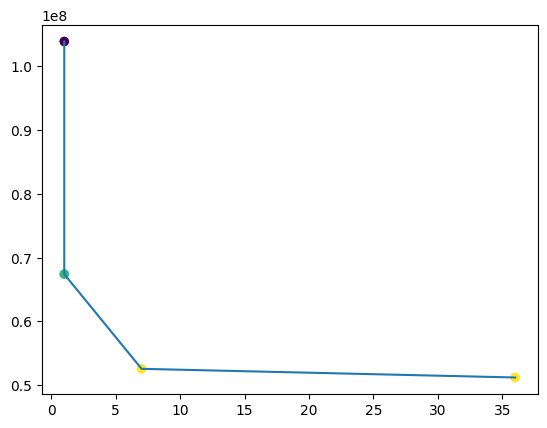

Vehículo 1 tramos activos: [(0, 3), (3, 9), (9, 14), (14, 7), (7, 11), (11, 0)] con distancia de 2231.55743617609
Vehículo 2 tramos activos: [(0, 0)] con distancia de 0.0
Vehículo 3 tramos activos: [(0, 4), (4, 0)] con distancia de 200.911475833152
Vehículo 4 tramos activos: [(0, 5), (5, 6), (6, 0)] con distancia de 997.4142504078047
Vehículo 5 tramos activos: [(0, 12), (12, 8), (8, 0)] con distancia de 144.18738125977967
Vehículo 6 tramos activos: [(0, 2), (2, 10), (10, 1), (1, 13), (13, 0)] con distancia de 1671.2831777537756


In [21]:
graficar(costos)
graficar_solucion(mejor_solucion)

In [22]:
import random
pheromonas=np.ones((len(depots)+len(clients)+1,len(depots)+len(clients)+1))
n_iteraciones=100
evaporacion=0.2
n_hormigas=10
mejor_solucion = None
mejor_costo = float('inf')
costos=[]
for it in range(n_iteraciones):
    hormigas = []
    for _ in range(n_hormigas):
        rutas = construir_solucion(deseabilidad, pheromonas)
        #print(rutas)
        costo = calcular_costo(rutas, distancias)
        hormigas.append((rutas, costo))
        if costo < mejor_costo:
            mejor_solucion = rutas
            mejor_costo = costo
            costos.append((it+1,costo,_))

    actualizar_feromonas(pheromonas, hormigas, evaporacion, 1)

    print(f"Iteración {it+1}, Mejor costo: {mejor_costo:.2f}")

# === RESULTADOS ===
print("\nMejor solución encontrada:")
for i, ruta in enumerate(mejor_solucion):
    print(f"  Vendedor {i+1}: {ruta}")
print(f"Costo total: {mejor_costo:.2f}")

Iteración 1, Mejor costo: 53778548.22
Iteración 2, Mejor costo: 53778548.22
Iteración 3, Mejor costo: 53778548.22
Iteración 4, Mejor costo: 53778548.22
Iteración 5, Mejor costo: 53778548.22
Iteración 6, Mejor costo: 53778548.22
Iteración 7, Mejor costo: 51409162.20
Iteración 8, Mejor costo: 51409162.20
Iteración 9, Mejor costo: 51409162.20
Iteración 10, Mejor costo: 51409162.20
Iteración 11, Mejor costo: 51409162.20
Iteración 12, Mejor costo: 51409162.20
Iteración 13, Mejor costo: 51409162.20
Iteración 14, Mejor costo: 51409162.20
Iteración 15, Mejor costo: 51409162.20
Iteración 16, Mejor costo: 51409162.20
Iteración 17, Mejor costo: 51409162.20
Iteración 18, Mejor costo: 51409162.20
Iteración 19, Mejor costo: 51409162.20
Iteración 20, Mejor costo: 51409162.20
Iteración 21, Mejor costo: 51409162.20
Iteración 22, Mejor costo: 51409162.20
Iteración 23, Mejor costo: 51409162.20
Iteración 24, Mejor costo: 51409162.20
Iteración 25, Mejor costo: 51409162.20
Iteración 26, Mejor costo: 5140916

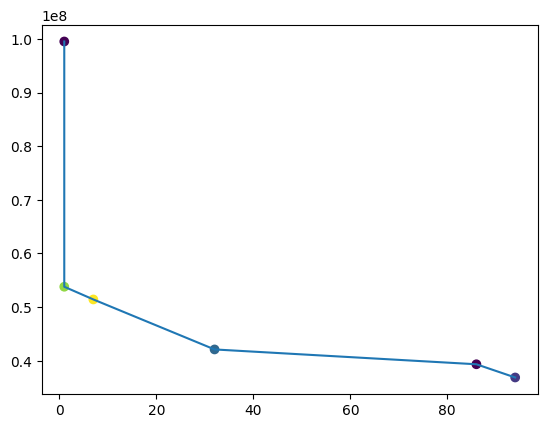

Vehículo 1 tramos activos: [(0, 5), (5, 0)] con distancia de 847.4309861185657
Vehículo 2 tramos activos: [(0, 6), (6, 1), (1, 13), (13, 11), (11, 3), (3, 0)] con distancia de 2071.8134751943016
Vehículo 3 tramos activos: [(0, 8), (8, 0)] con distancia de 144.17067460394733
Vehículo 4 tramos activos: [(0, 12), (12, 0)] con distancia de 3.4483424045138693
Vehículo 5 tramos activos: [(0, 2), (2, 10), (10, 7), (7, 14), (14, 9), (9, 0)] con distancia de 1506.0895524645125
Vehículo 6 tramos activos: [(0, 4), (4, 0)] con distancia de 200.911475833152


In [23]:
graficar(costos)
graficar_solucion(mejor_solucion)

In [24]:
import random
pheromonas=np.ones((len(depots)+len(clients)+1,len(depots)+len(clients)+1))
n_iteraciones=1000
evaporacion=0.2
n_hormigas=100
mejor_solucion = None
mejor_costo = float('inf')
costos=[]
for it in range(n_iteraciones):
    hormigas = []
    for _ in range(n_hormigas):
        rutas = construir_solucion(deseabilidad, pheromonas)
        #print(rutas)
        costo = calcular_costo(rutas, distancias)
        hormigas.append((rutas, costo))
        if costo < mejor_costo:
            mejor_solucion = rutas
            mejor_costo = costo
            costos.append((it+1,costo,_))

    actualizar_feromonas(pheromonas, hormigas, evaporacion, 1)
    if it%100==0:
      print(f"Iteración {it+1}, Mejor costo: {mejor_costo:.2f}")

# === RESULTADOS ===
print("\nMejor solución encontrada:")
for i, ruta in enumerate(mejor_solucion):
    print(f"  Vendedor {i+1}: {ruta}")
print(f"Costo total: {mejor_costo:.2f}")

Iteración 1, Mejor costo: 47859467.83
Iteración 101, Mejor costo: 25304437.46
Iteración 201, Mejor costo: 25304437.46
Iteración 301, Mejor costo: 24995961.96
Iteración 401, Mejor costo: 24995961.96
Iteración 501, Mejor costo: 24995961.96
Iteración 601, Mejor costo: 24995961.96
Iteración 701, Mejor costo: 24995961.96
Iteración 801, Mejor costo: 24995961.96
Iteración 901, Mejor costo: 24995961.96

Mejor solución encontrada:
  Vendedor 1: [0, 0]
  Vendedor 2: [0, 4, 0]
  Vendedor 3: [0, 5, 6, 2, 10, 7, 14, 9, 3, 11, 13, 1, 0]
  Vendedor 4: [0, 8, 0]
  Vendedor 5: [0, 0]
  Vendedor 6: [0, 12, 0]
Costo total: 24995961.96


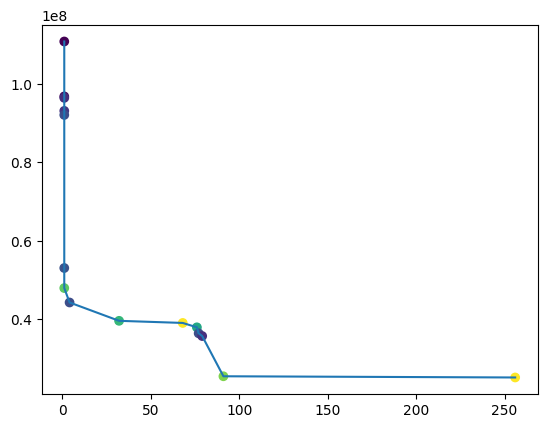

Vehículo 1 tramos activos: [(0, 0)] con distancia de 0.0
Vehículo 2 tramos activos: [(0, 4), (4, 0)] con distancia de 200.911475833152
Vehículo 3 tramos activos: [(0, 5), (5, 6), (6, 2), (2, 10), (10, 7), (7, 14), (14, 9), (9, 3), (3, 11), (11, 13), (13, 1), (1, 0)] con distancia de 2409.3924307719885
Vehículo 4 tramos activos: [(0, 8), (8, 0)] con distancia de 144.17067460394733
Vehículo 5 tramos activos: [(0, 0)] con distancia de 0.0
Vehículo 6 tramos activos: [(0, 12), (12, 0)] con distancia de 3.4483424045138693


In [25]:
graficar(costos)
graficar_solucion(mejor_solucion)

## **Generacion csv verificación**

In [26]:
verificacion={
    "VehicleID":[],
    "Ruta":[],
    "Distancia (Km)":[],
    "# Destinos entregados":[],
    "Range(Km)":[]
}
for v,sol in enumerate(mejor_solucion):
  verificacion["VehicleID"].append(hormigas_plantillas[v]["VehicleID"])
  verificacion["Ruta"].append("-".join(map(str,sol)))
  verificacion["Distancia (Km)"].append(calcular_costo([sol],distancias))
  verificacion["# Destinos entregados"].append(len(sol)-2)
  verificacion["Range(Km)"].append(hormigas_plantillas[v]["Range"])
df=pd.DataFrame(verificacion)
df.to_csv("verificacion_metaheurística_antcolony_3.csv")
df

,VehicleID,Ruta,Distancia (Km),# Destinos entregados,Range(Km)
0,1,0-0,0.000000e+00,0,1720
1,2,0-4-0,2.511393e+06,1,1510
2,3,0-5-6-2-10-7-14-9-3-11-13-1-0,2.063933e+07,11,1300
3,4,0-8-0,1.802133e+06,1,1500
4,5,0-0,0.000000e+00,0,870
5,6,0-12-0,4.310428e+04,1,1200
